In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnsit-test/crnn_mnist_submission.csv
/kaggle/input/mnsit-test/__results__.html
/kaggle/input/mnsit-test/__notebook__.ipynb
/kaggle/input/mnsit-test/__output__.json
/kaggle/input/mnsit-test/model.png
/kaggle/input/mnsit-test/custom.css
/kaggle/input/mnsit-test/__results___files/__results___5_0.png
/kaggle/input/mnsit-test/__results___files/__results___8_1.png


In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 435kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.00MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.96MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce size
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # 10 output classes (digits 0-9)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation (handled in loss function)
        return x

# ✅ 3️⃣ Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda is available")
else:
    print("Cuda is not available")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()  # Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5  # Change as needed


Cuda is not available


In [7]:
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.2527
Epoch [2/5], Loss: 0.1549
Epoch [3/5], Loss: 0.0231
Epoch [4/5], Loss: 0.0033
Epoch [5/5], Loss: 0.1074


In [8]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

train_acc = evaluate(model, train_loader)
test_acc = evaluate(model, test_loader)
print(f'Train Accuracy: {train_acc:.2%}')
print(f'Test Accuracy: {test_acc:.2%}')

Train Accuracy: 99.37%
Test Accuracy: 98.78%


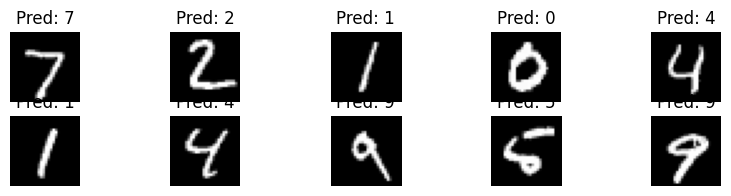

In [9]:
import numpy as np

def show_sample_predictions(model, loader):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images[:10].to(device), labels[:10].to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy().squeeze()

    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f'Pred: {predicted[i].item()}')
        plt.axis('off')
    plt.show()

# 🔹 Show predictions on test set
show_sample_predictions(model, test_loader)
